In [1]:
from typing import Type

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoConfig, DataCollatorWithPadding, get_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import AdamW
from torch import Tensor
from datasets import load_from_disk
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import numpy as np

d:\Acads\Sem - 1\CS 505 Natural Language Processing\Research Project Repo\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CHECKPOINT = "google-bert/bert-large-cased-whole-word-masking-finetuned-squad"
# Model card: https://huggingface.co/google-bert/bert-large-cased-whole-word-masking-finetuned-squad

In [4]:
## Tokenizer code
checkpoint_model_tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, return_tensors='pt')

def tokenize_and_align_dataset(sample):
    question_string = sample['question']
    answer_string = sample["answer"]
    final_input_string = f"{question_string} [SEP] {answer_string}"
    tokenized_inputs = checkpoint_model_tokenizer(final_input_string, add_special_tokens=True)
    return tokenized_inputs


In [5]:
# Importing dataset
visa_qa_dataset = load_from_disk("../Datasets/Visa_QA_V3")
visa_qa_dataset

DatasetDict({
    train: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted'],
        num_rows: 19962
    })
    validation: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted'],
        num_rows: 3327
    })
    test: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted'],
        num_rows: 3327
    })
})

In [6]:
preprocessed_visa_qa = visa_qa_dataset.map(tokenize_and_align_dataset, batched=False)
preprocessed_visa_qa

Map: 100%|██████████| 3327/3327 [00:04<00:00, 772.11 examples/s]


DatasetDict({
    train: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19962
    })
    validation: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3327
    })
    test: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3327
    })
})

In [7]:
all_string_lens = []
all_token_lens = []
def get_lens(sample):
    total_string_len = len(sample['question'].split()) + len(sample['answer'].split())
    
    all_string_lens.append(total_string_len)
    all_token_lens.append(len(sample['input_ids']))
    return sample

preprocessed_visa_qa['train'].map(get_lens)


Dataset({
    features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 19962
})

ValueError: max() arg is an empty sequence

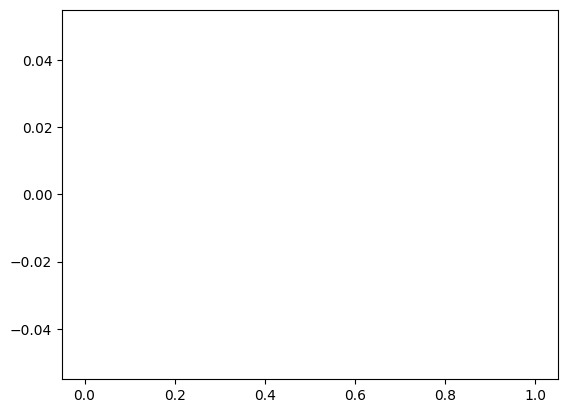

In [8]:
plt.hist(all_string_lens)
print(max(all_string_lens))
plt.show()

3430


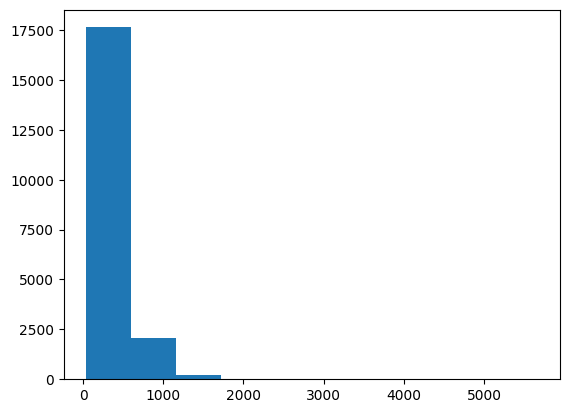

In [ ]:
plt.hist(all_token_lens)
print(len([x for x in all_token_lens if x > 512]))
plt.show()

Since only 3430 will be dropped, we will be dropping rows whose input ID lens are greater than 512

In [9]:
filtered_preprocessed_visa_qa = preprocessed_visa_qa.filter(lambda x: len(x['input_ids']) <= 512)
filtered_preprocessed_visa_qa.set_format(type='torch',
                                          columns=['input_ids', 'attention_mask', 'token_type_ids', 'vote_score'])
filtered_preprocessed_visa_qa

Filter:   0%|          | 0/3327 [00:00<?, ? examples/s]

Filter: 100%|██████████| 3327/3327 [00:01<00:00, 1682.48 examples/s]


DatasetDict({
    train: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16532
    })
    validation: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2745
    })
    test: Dataset({
        features: ['meta_tags', 'question', 'answer', 'vote_score', 'Accepted', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2725
    })
})

In [10]:
## Data Collator for dynamic input adjustment
data_collator = DataCollatorWithPadding(checkpoint_model_tokenizer)

train_dataloader = DataLoader(filtered_preprocessed_visa_qa['train'].select(range(32)),
                              shuffle=True,
                              batch_size=32,
                              collate_fn=data_collator
                              )

val_dataloader = DataLoader(filtered_preprocessed_visa_qa['validation'].select(range(1)),
                              shuffle=True,
                              batch_size=1,
                              collate_fn=data_collator
                              )

In [11]:
class CorrectnessModuleLLM(nn.Module):
    def __init__(self: Type["CorrectnessModuleLLM"],
                 checkpoint: str) -> None:
        super(CorrectnessModuleLLM, self).__init__()
        self.embedding_body = AutoModel.from_pretrained(checkpoint, 
                                                        config=AutoConfig.from_pretrained(checkpoint,
                                                                                          output_attention=True,
                                                                                          output_hidden_states=False))
        self.logit_transform = nn.Linear(in_features = 1024, 
                                         out_features = 1,
                                         bias=True)
        # self.output_transform = nn.Sigmoid()
        return
    
    def forward(self: Type["CorrectnessModuleLLM"],
                input_ids: Tensor,
                attention_mask: Tensor,
                token_type_ids) -> Tensor:
        llm_embeddings = self.embedding_body(input_ids=input_ids,
                                             attention_mask=attention_mask,
                                             token_type_ids = token_type_ids)
        cls_token_output = llm_embeddings.last_hidden_state[0]
        logits = self.logit_transform(cls_token_output)
        # output_prob = self.output_transform(logits)
        return logits

    def save_pretrained(self, save_directory):
        # Save the base model and configuration
        self.embedding_body.save_pretrained(save_directory)
        # Save the custom layers' weights
        torch.save(self.logit_transform.state_dict(), f"{save_directory}/logit_transform.pt")
        # torch.save(self.output_transform.state_dict(), f"{save_directory}/output_transform.pt")
    
    @classmethod
    def from_pretrained(cls, save_directory, *model_args, **kwargs):
        # Load the configuration
        config = AutoConfig.from_pretrained(save_directory)
        config.checkpoint = save_directory  # Ensure checkpoint is set
        model = cls(config)
        # Load base model weights
        model.embedding_body = AutoModel.from_pretrained(save_directory, config=config)
        # Load custom layers' weights
        model.logit_transform.load_state_dict(torch.load(f"{save_directory}/logit_transform.pt"))
        # model.output_transform.load_state_dict(torch.load(f"{save_directory}/output_transform.pt"))
        return model

In [ ]:
correctness_model = CorrectnessModuleLLM(checkpoint=CHECKPOINT)

: 

In [ ]:
optimizer = AdamW(correctness_model.parameters(), lr=5e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(val_dataloader)))

criterion = MSELoss()
training_loss_history = []
validation_loss_history = []
for epoch in range(num_epochs):
    train_loss_accum = 0
    val_loss_accum = 0
    correctness_model.train()
    for batch in train_dataloader:
        batch = {k: v for k, v in batch.items()}
        votes_prediction = correctness_model(**{k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']})
        train_loss = criterion(votes_prediction, batch['vote_score'])
        train_loss_accum += train_loss
        train_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)

    correctness_model.eval()
    for batch in val_dataloader:
        batch = {k: v for k, v in batch.items()}
        with torch.no_grad():
            outputs = correctness_model(**{k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']})
        val_loss = criterion(votes_prediction, batch['vote_score'])
        val_loss_accum += val_loss

        progress_bar_eval.update(1)
    correctness_model.save_pretrained(f"../Model_Checkpoints/correct-llm-bert-checkpoint-epoch-{epoch}")
    print("====== Epoch: ", epoch, " ======")
    print(f"Training RMSE: {np.sqrt(train_loss_accum)}")
    print(f"Validation RMSE: {np.sqrt(val_loss_accum)}")
    training_loss_history.append(train_loss_accum)
    validation_loss_history.append(val_loss_accum)

1


  0%|          | 0/1 [00:00<?, ?it/s]